# Import Libraries

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
import tensorflow.compat.v2 as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.data import Dataset

from __future__ import absolute_import, division, print_function, unicode_literals
from collections import Counter
# Enable eager execution
tf.enable_v2_behavior()

## Load the dataset

In [2]:
%%time
import importlib

def import_or_install(library):
    try:
        importlib.import_module(library)
        print(f"{library} is already installed.")
    except ImportError:
        print(f"{library} is not installed. Installing...")
        !pip install {library}
        print(f"{library} has been successfully installed.")

# Example usage:
libraries_to_check = ["tensorflow_datasets"]

for library in libraries_to_check:
    import_or_install(library)

tensorflow_datasets is already installed.
CPU times: total: 141 ms
Wall time: 156 ms


In [3]:
import tensorflow_datasets as tfds

(bn_train, bn_validation, bn_test),bn_info = tfds.load(

    name = 'beans',

    split = ['train', 'validation', 'test'],

    as_supervised = True,

    with_info = True)

print(bn_info)

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_dir='C:\\Users\\kelby\\tensorflow_datasets\\beans\\0.1.0',
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_exam

In [4]:
# the training dataset has features/image and label/target
for image, label in bn_train.take(1):  # example is (image, label)
  print(image.shape, label)
  

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


In [5]:
print(bn_info.features["label"].num_classes)
print(bn_info.features["label"].names)

3
['angular_leaf_spot', 'bean_rust', 'healthy']


In [6]:
print(bn_info.features.shape)
print(bn_info.features.np_dtype)
print(bn_info.features['image'].shape)
print(bn_info.features['image'].np_dtype)

{'image': (500, 500, 3), 'label': ()}
{'image': <class 'numpy.uint8'>, 'label': <class 'numpy.int64'>}
(500, 500, 3)
<class 'numpy.uint8'>


In [7]:
# Assuming you have a pre-loaded image dataset `image_dataset`

# Convert dataset to a NumPy array (images and labels)
data_array = tfds.as_numpy(bn_train)

for imgs, labels in data_array:
    print (imgs.shape, labels.shape)
    break

(500, 500, 3) ()


In [8]:

# Image parameters:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)
# the inputs are the image, label and target size
def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label
#apply normalize_image() function to each of image avoid writing a loop
bn_train = bn_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_train = bn_train.cache().shuffle(1000)
bn_train = bn_train.shuffle(bn_info.splits['train'].num_examples)
bn_train = bn_train.batch(batch_size)
bn_train = bn_train.prefetch(tf.data.experimental.AUTOTUNE)


Perform the similar tasks for the validation dataset

In [9]:
bn_validation = bn_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_validation = bn_validation.batch(batch_size)
bn_validation = bn_validation.cache()
bn_validation = bn_validation.prefetch(tf.data.experimental.AUTOTUNE)

bn_test = bn_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
bn_test = bn_test.batch(batch_size)
bn_test = bn_test.cache()
bn_test = bn_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    # since we handle labels only in this funciton, we discard the first parameter that is image
    # we take out one batch that is 32 images and lables
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    # the l_labels is a nest of list , for example [ [1, 0, 2, ...], [2,1, 1,..], ..]
    # return a single list by using list comprehension
    #[1, 0, 2, ..., 2, 1, 1, ..]
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(bn_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(bn_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(bn_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({np.int64(1): 348, np.int64(0): 345, np.int64(2): 341})
The distribution of validation labels is:  Counter({np.int64(1): 45, np.int64(2): 44, np.int64(0): 44})
The distribution of test labels is:  Counter({np.int64(0): 43, np.int64(1): 43, np.int64(2): 42})


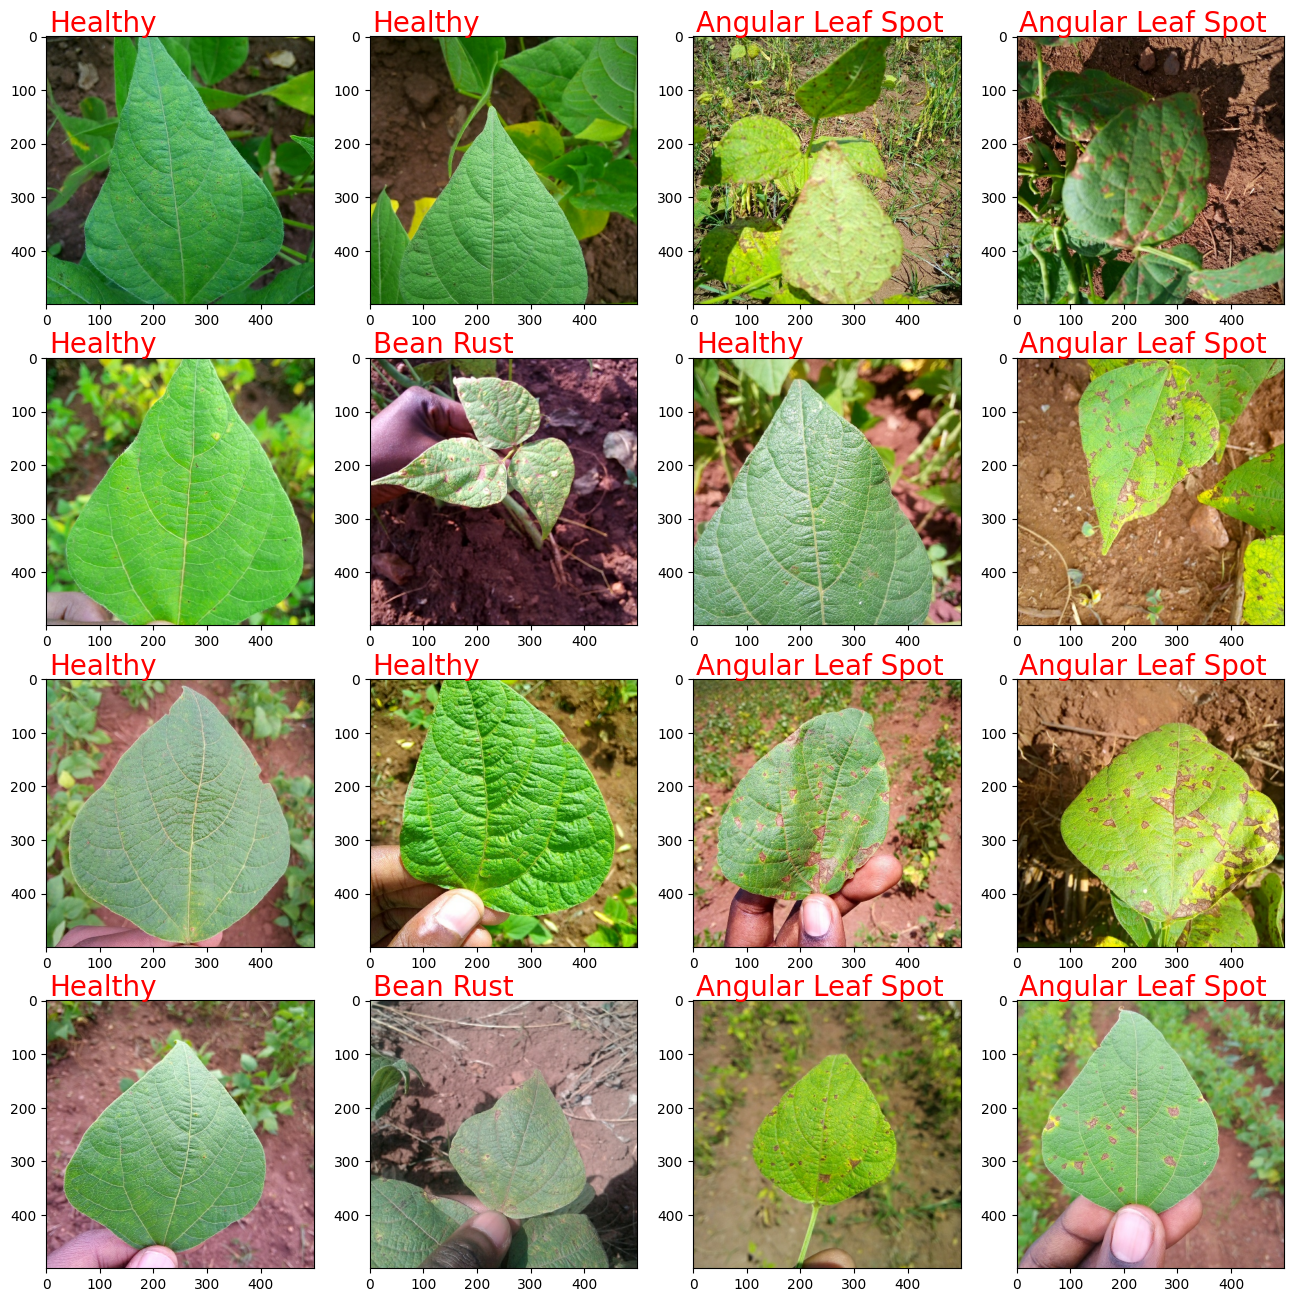

In [11]:
# take out one batch that is 32 images
example = bn_train.take(1)
# each batch has two componets, image and label
# sample=(image, lable)
for sample in example:
    image, label = sample[0], sample[1]
    #convert them to np
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    # we label the subplots using names instead of magic numbers such as 0, 1 and 2
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

## Convert TensorFlow Dataset to Numpy Array to Inspect the Pixel Values

In [12]:
# Convert dataset to a NumPy array (images and labels)
image_array = tfds.as_numpy(bn_train)

for img in image_array:
    print (imgs.shape)
    break

(500, 500, 3)


In [14]:
print(f'The maximum value of pixels = {np.amax(img[0])}; the minimum value of pixels ={np.amin(img[0])}' )

The maximum value of pixels = 1.0; the minimum value of pixels =0.0


In [15]:
input_shape =imgs.shape
input_shape

(500, 500, 3)

In [25]:
model = models.Sequential()
# Get the image size using codes instead of using magic number (32,32,3)
input_shape =imgs.shape
print(f'The input shape = {input_shape}')
# The first Convolution layer has 32 filters, with the output has 32 channels. The size of the filter is 3*3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= input_shape))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Followed by 2*2 pooling window 
model.add(layers.MaxPooling2D((2, 2)))
# The second Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 3*3
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# The Third Convolution layer has 64 filters, with the output has 64 channels. The size of the filter is 2*2
model.add(layers.Conv2D(64, (2, 2), activation='relu'))

The input shape = (500, 500, 3)


We use summary to get an overall look at what our layers are doing and our parameters

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 498, 498, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 247, 247, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 121, 121, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 120, 120, 64)        │          16,448 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,768 (284.25 KB)

 Trainable params: 72,768 (284.25 KB)

 Non-trainable params: 0 (0.00 B)

Now, we need classifier layers (Dense) layers in order to complete the classification setup. 

In [27]:
# Convert  feature matrix from 4D to 2D
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# Add dropout layer
model.add(layers.Dropout(0.2))
# Last layer must have 3 neuron to match the amount of labels we have
model.add(layers.Dense(3))

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
history = model.fit(
    bn_train,
    epochs=20,
    validation_data=bn_test,  # Pass the dataset object directly
    callbacks=[callback], verbose=1
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3746 - loss: 5.5603 - val_accuracy: 0.3906 - val_loss: 1.0459
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5286 - loss: 0.9384 - val_accuracy: 0.6406 - val_loss: 0.7906
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5874 - loss: 0.8822 - val_accuracy: 0.5938 - val_loss: 0.9654
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5941 - loss: 0.8790 - val_accuracy: 0.6328 - val_loss: 0.8129
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6309 - loss: 0.7820 - val_accuracy: 0.8047 - val_loss: 0.7209
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6613 - loss: 0.7469 - val_accuracy: 0.8125 - val_loss: 0.6272
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7230 - loss: 0.6131 - val_accuracy: 0.7500 - val_loss: 0.6350
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7662 - loss: 0.5577 - val_accuracy: 0.7891 - val_loss:

## Evaluating the model

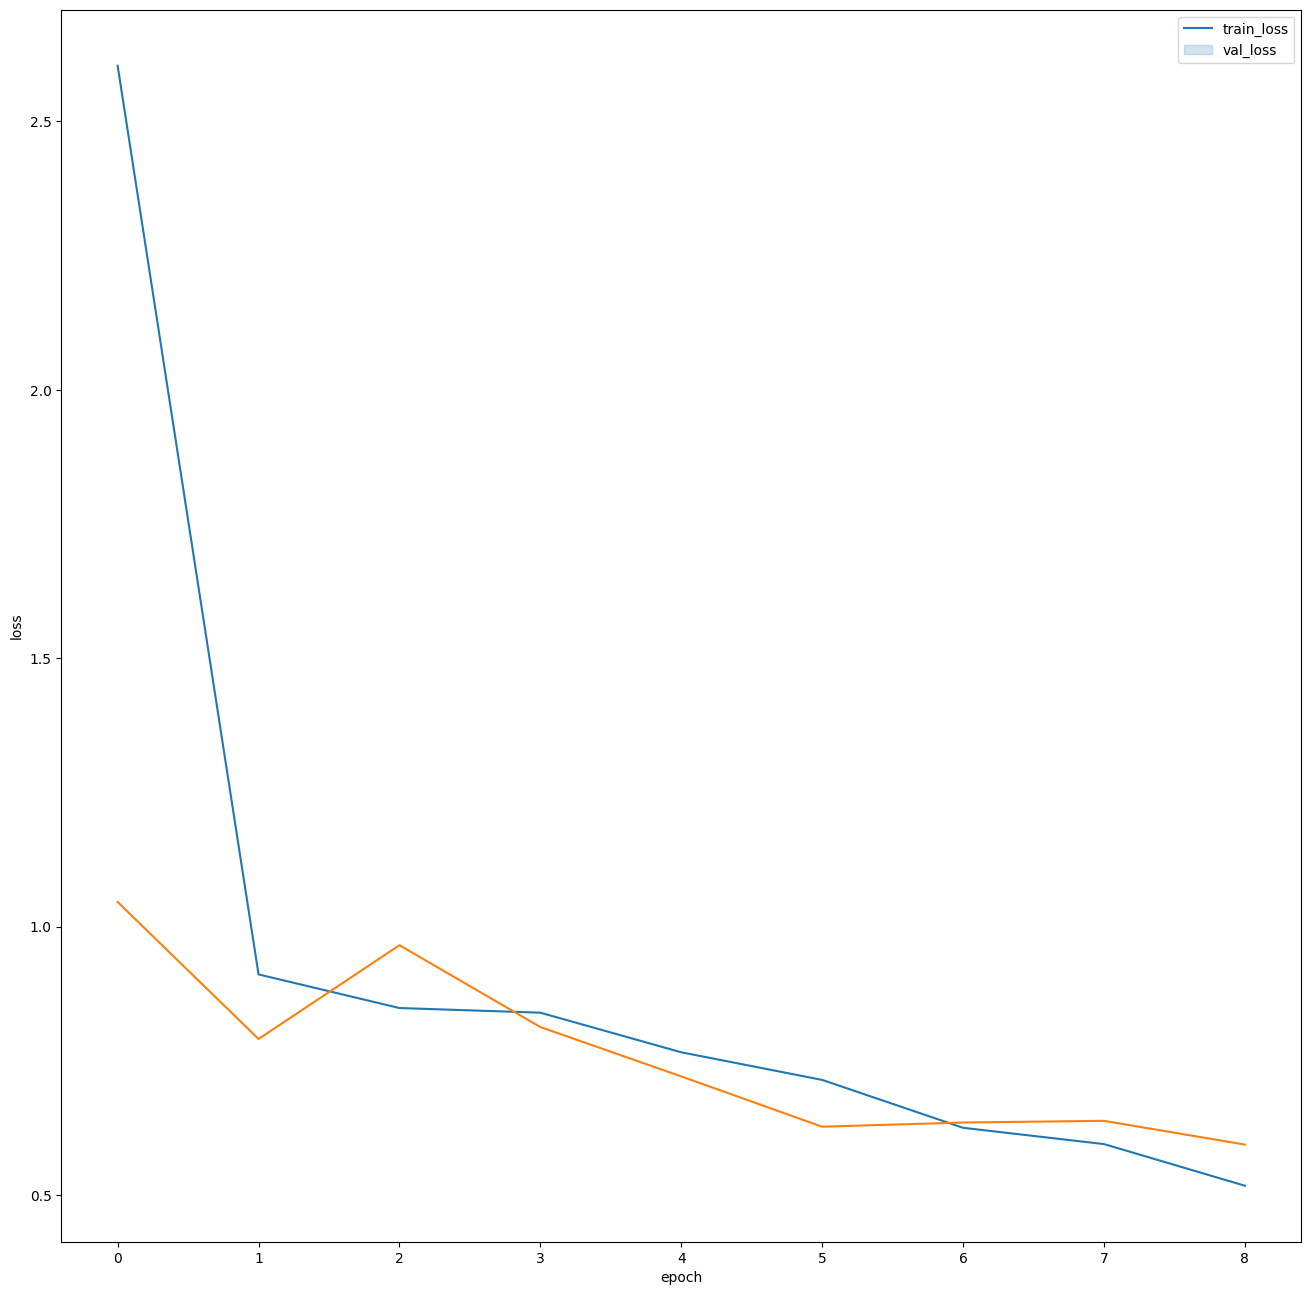

In [32]:
trainhist = pd.DataFrame(history.history)
trainhist['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x ='epoch', y ='loss', data = trainhist)
# Plot validation loss
sns.lineplot(x ='epoch', y ='val_loss', data = trainhist)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

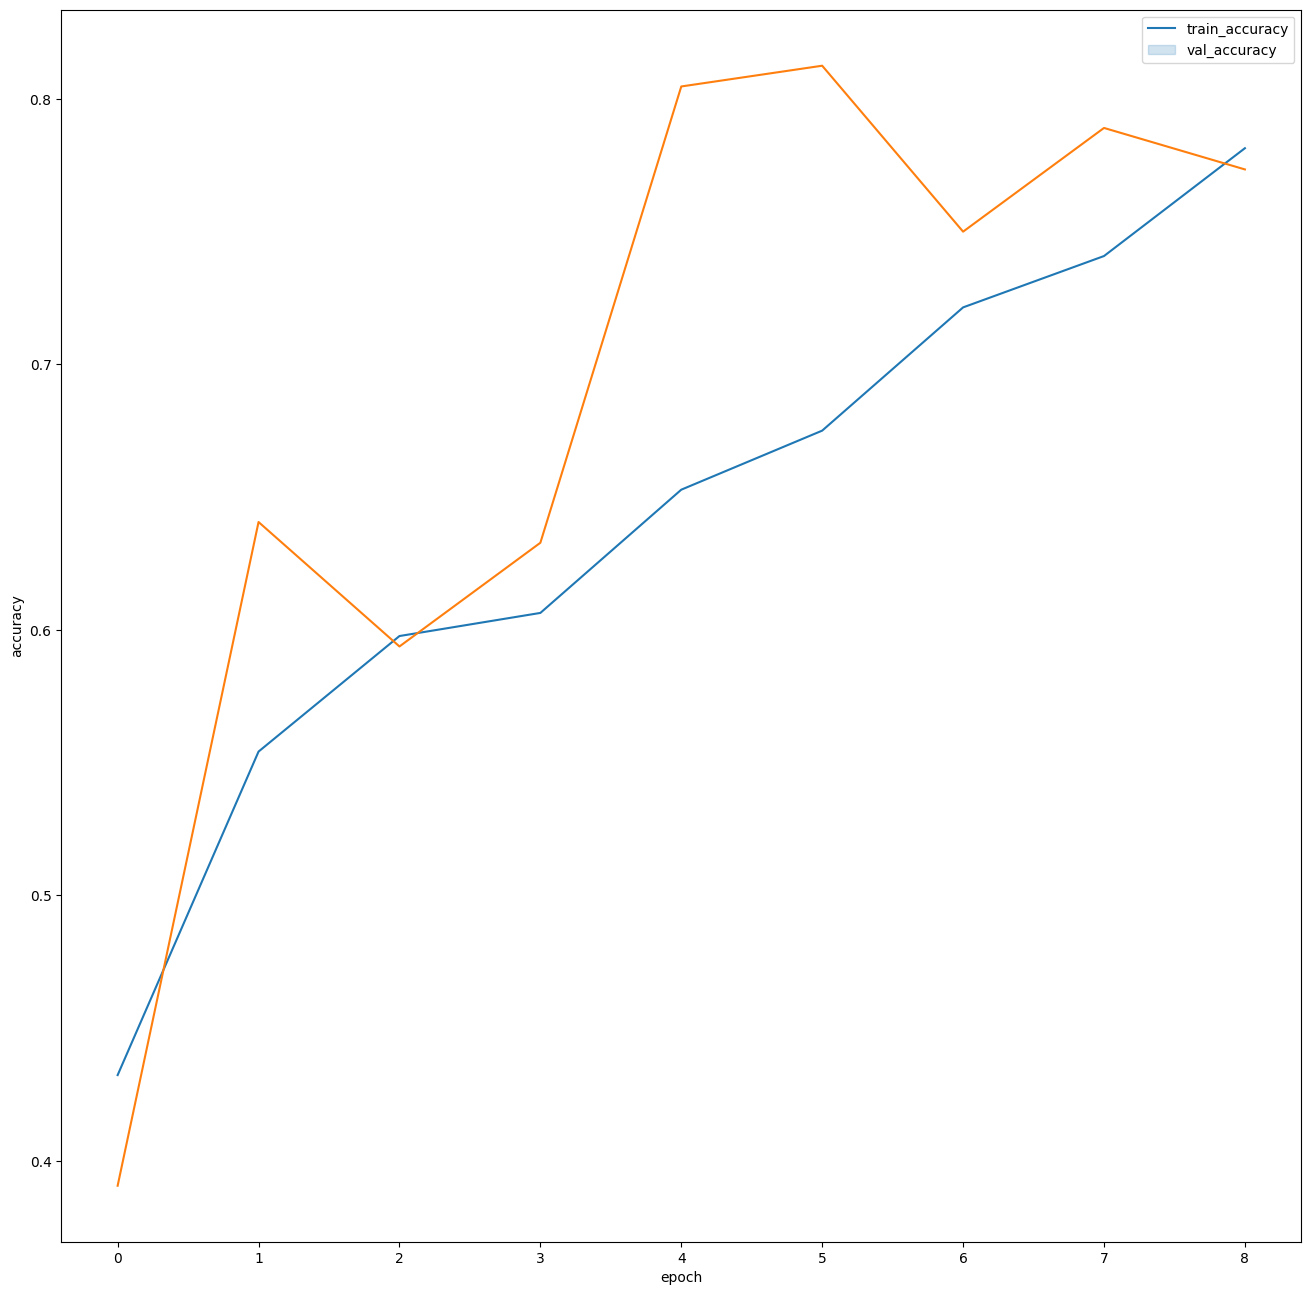

In [33]:
sns.lineplot(x = 'epoch', y = 'accuracy', data = trainhist)
# Plot validation loss
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = trainhist)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [35]:
test_loss, test_acc = model.evaluate(bn_test, verbose=0)
print(f'Test loss is {test_loss:.2f} and test accuracy is {test_acc:.2f}')

Test loss is 0.59 and test accuracy is 0.77


Model peaks at just over 80% which isn't bad, but we end at 77%. We could possibly see improvement from data augmentation. <br />
I believe the model is overfitting due to refined scores in training data but decreased performance on test data. 

# Beginning data augmentation

In [41]:
data_aug = tf.keras.Sequential([
    Input(shape=(image_height, image_width, num_channels)),  
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomZoom(height_factor=0.1)
])


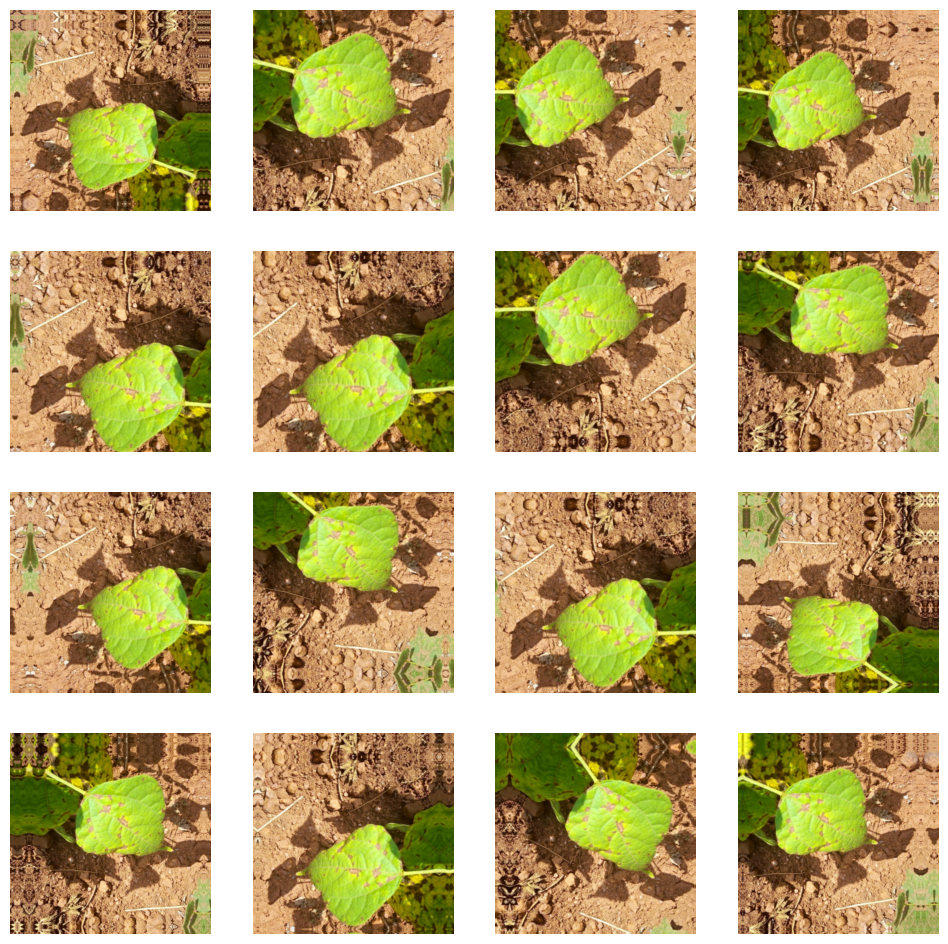

In [44]:
plt.figure(figsize=(12, 12))
for img, lab in bn_train.take(1):
  for i in range(16):
    aug_images = data_aug(img)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(aug_images[0].numpy().astype("float32"))
    plt.axis("off")

## Configure new model for augmentation

In [50]:
model2 = tf.keras.Sequential([
    # Data augmentation
    data_aug,
    # Data normalization
    tf.keras.layers.Rescaling(1./255),

    # First Conv Layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    # Second Conv Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third & Fourth Conv Layers
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (2, 2), activation='relu'),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3)
])


In [51]:
model2.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [53]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 500, 500, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 500, 500, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 498, 498, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 247, 247, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 121, 121, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 120, 120, 64)        │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 921600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │      58,982,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,055,427 (225.28 MB)

 Trainable params: 59,055,427 (225.28 MB)

 Non-trainable params: 0 (0.00 B)

Significant increase in total parameters. While more expensive, this should yield better results. 

In [56]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3)
epochs = 20
history = model2.fit(
    bn_train,
    validation_data = bn_test,
    epochs = epochs,
    callbacks = [callback], 
    verbose = 1
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.3435 - loss: 1.1268 - val_accuracy: 0.3281 - val_loss: 1.0986
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3320 - loss: 1.0986 - val_accuracy: 0.3281 - val_loss: 1.0986
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3084 - loss: 1.0987 - val_accuracy: 0.3359 - val_loss: 1.0986
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3203 - loss: 1.0987 - val_accuracy: 0.3359 - val_loss: 1.0986
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3427 - loss: 1.0986 - val_accuracy: 0.3359 - val_loss: 1.0986
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.3473 - loss: 1.0986 - val_accuracy: 0.3359 - val_loss: 1.0986
CPU times: total: 1h 39min 26s
Wall time: 7min 17s


# Evaluating the second model

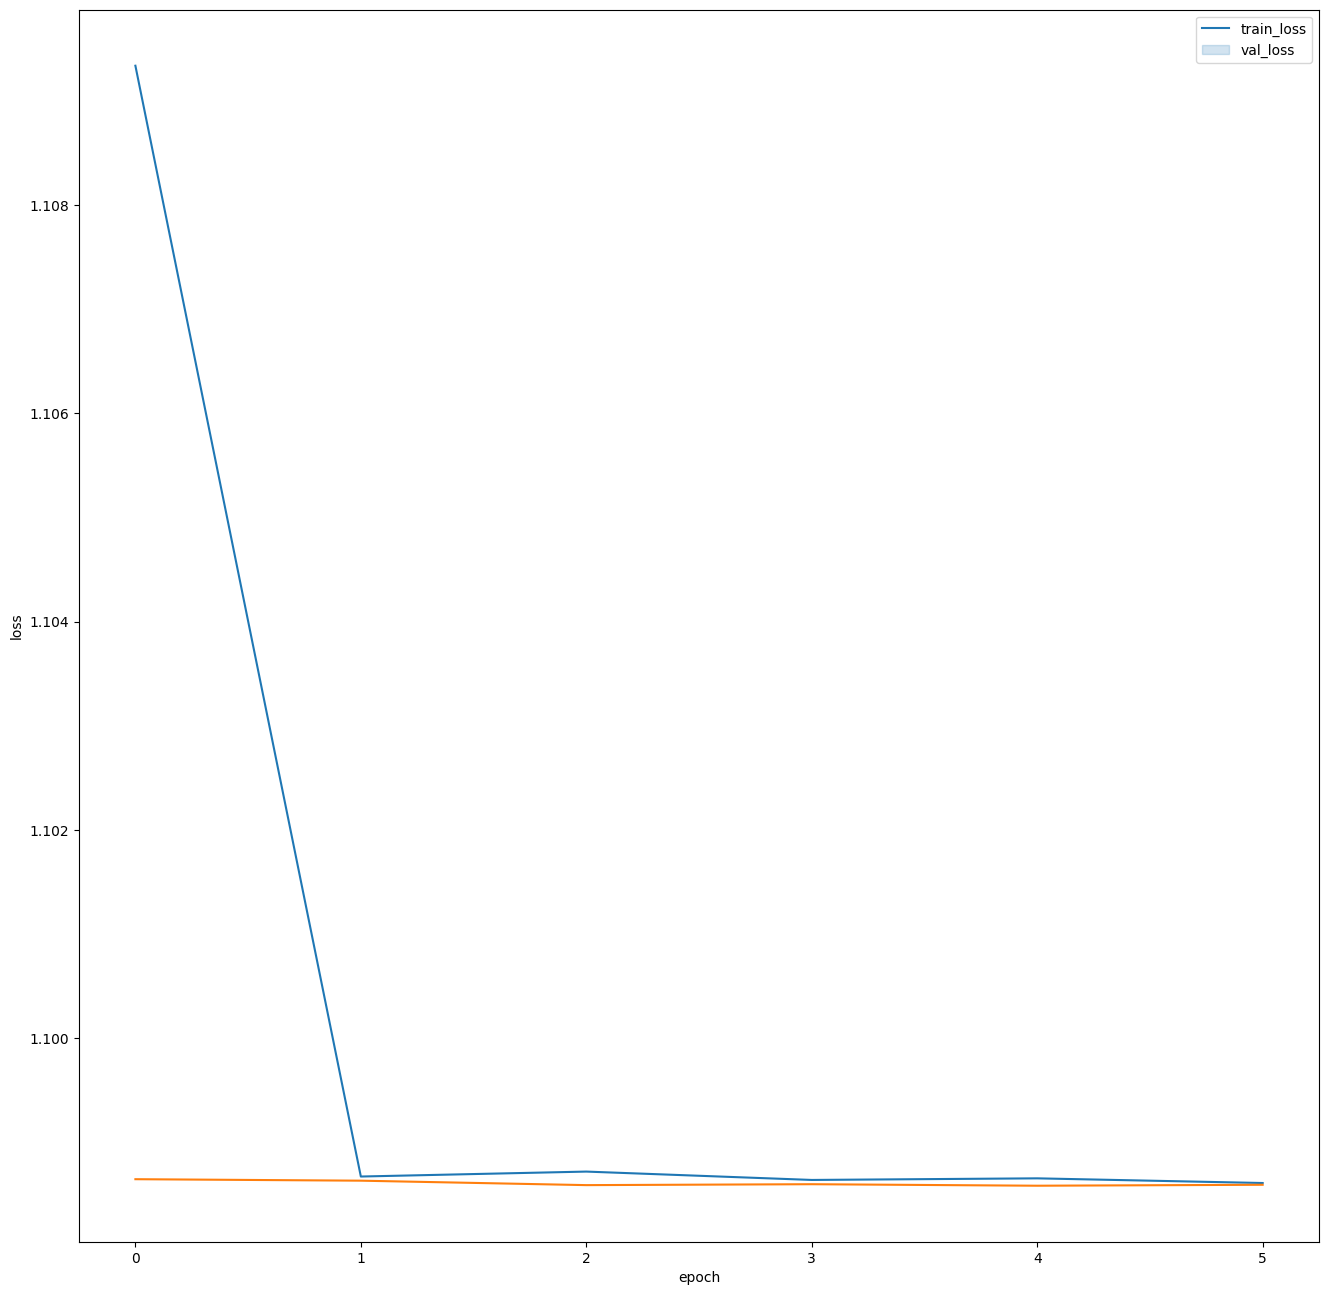

In [57]:
trainhist2 = pd.DataFrame(history.history)
trainhist2['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x ='epoch', y ='loss', data = trainhist2)
# Plot validation loss
sns.lineplot(x ='epoch', y ='val_loss', data = trainhist2)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

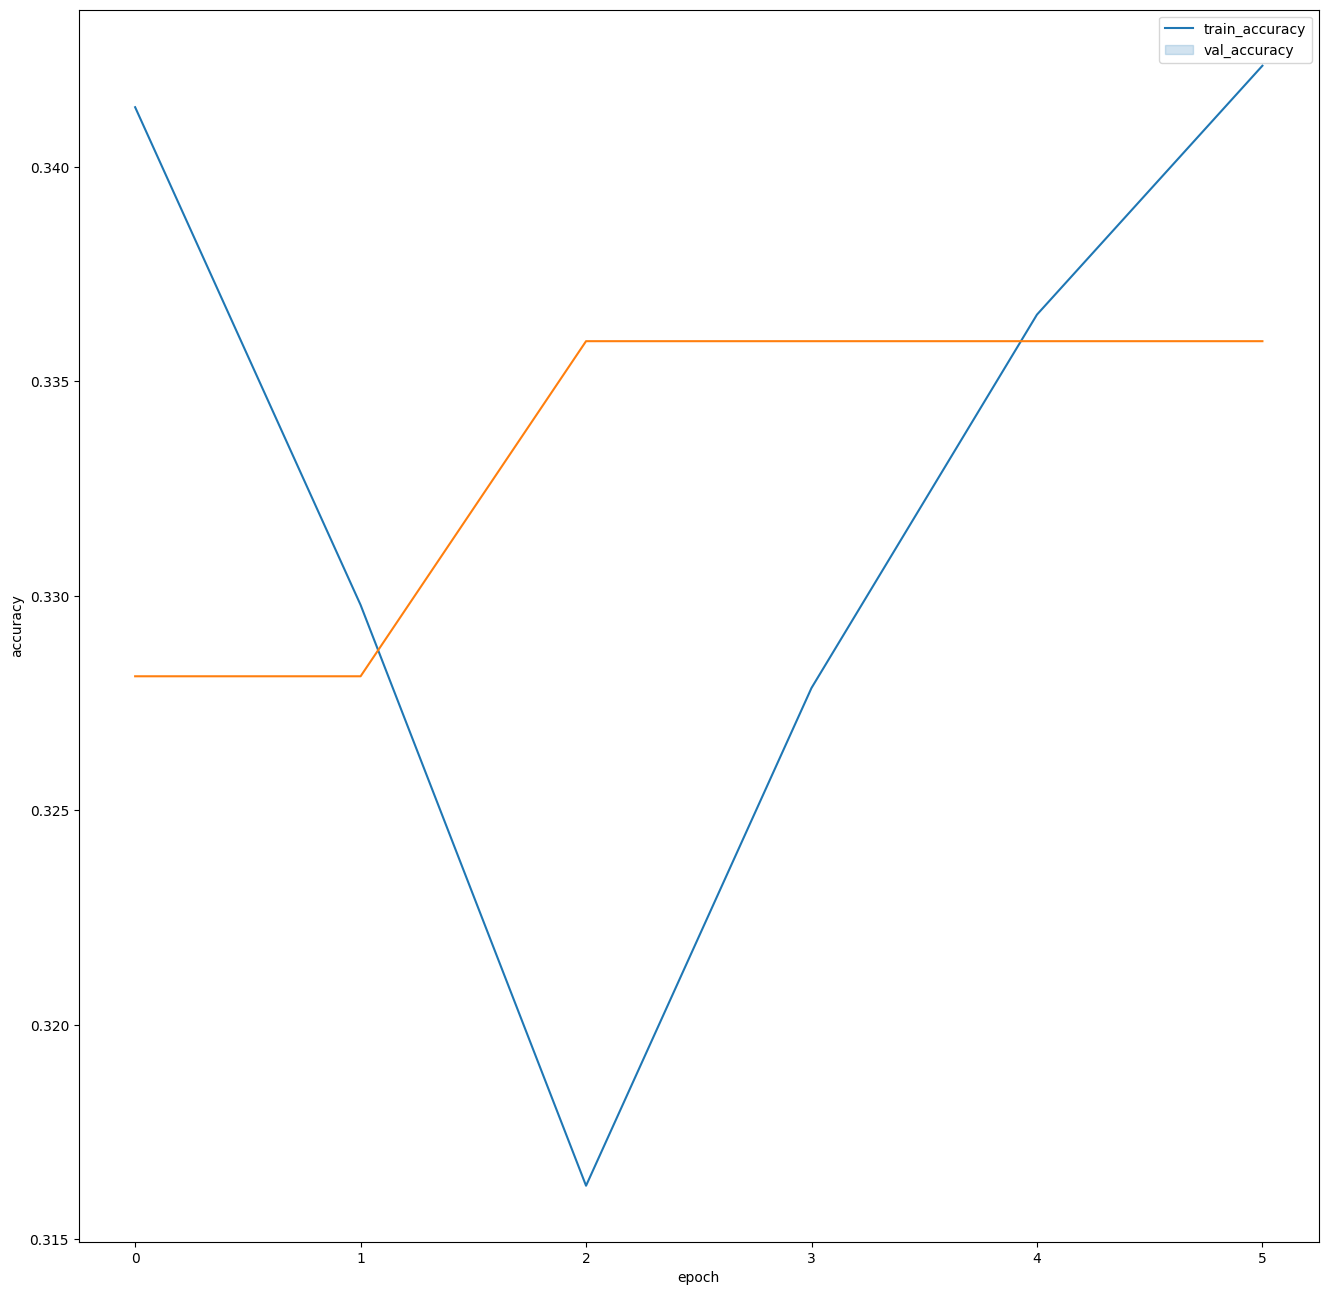

In [59]:
sns.lineplot(x = 'epoch', y = 'accuracy', data = trainhist2)
# Plot validation loss
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = trainhist2)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [61]:
test_loss, test_acc = model2.evaluate(bn_test, verbose=0)
print(f'Test loss is {test_loss:.2f} and test accuracy is {test_acc:.2f}')

Test loss is 1.10 and test accuracy is 0.34


It would appear that the second model is underfitting, likely do to too much variation in data spread. 

# Pre Trained Model

In [63]:
# Specify the image size for our dataset
IMG_SHAPE = (image_height, image_width, num_channels)

MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape = IMG_SHAPE,
                                               include_top=False, # Remove the fully-connected layer
                                               weights='imagenet') # Pre-training on ImageNet

C:\Users\kelby\tf-gpu-env\lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [64]:
MobileNetV3Large_model.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_4 (Rescaling)       │ (None, 500, 500, 3)       │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv (Conv2D)                 │ (None, 250, 250, 16)      │             432 │ rescaling_4[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_bn (BatchNormalization)  │ (None, 250, 250, 16)      │              64 │ conv[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 250, 250, 16)      │               0 │ conv_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 250, 250, 16)      │             144 │ activation[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_bn    │ (None, 250, 250, 16)      │              64 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 250, 250, 16)      │               0 │ expanded_conv_depthwise_b… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 250, 250, 16)      │             256 │ re_lu[0][0]                │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_bn      │ (None, 250, 250, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_add (Add)       │ (None, 250, 250, 16)      │               0 │ activation[0][0],          │
│                               │                           │                 │ expanded_conv_project_bn[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand        │ (None, 250, 250, 64)      │           1,024 │ expanded_conv_add[0][0]    │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_1_expand_bn     │ (None, 250, 250, 64)      │             256 │ expanded_conv_1_expand[0]… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 250, 250, 64)      │               

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [68]:
MobileNetV3Large_model.trainable = False
# This prevents us from retraining the large model

In [69]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [70]:
image_batch, label_batch = next(iter(bn_train))
feature_batch = MobileNetV3Large_model(image_batch)
print(feature_batch.shape)

(32, 16, 16, 960)


The above reflects a 4D tensor, so we need to flatten that to 2D

In [71]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


In [72]:
global_average_layer = tf.keras.layers.Flatten()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 245760)


# Add Classifier
This sets the top layer to match the output we need against the number of labels we have. 

In [75]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(f'The size of the predicted value for a given batch = {prediction_batch.shape}')

The size of the predicted value for a given batch = (32, 3)


### Now we create the model via transfer learning

In [76]:
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_aug(inputs)
x = preprocess_input(x)
x = MobileNetV3Large_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Configure the model
We set loss function to SparseCategoricalCrossentropy because our label is encoded. 

In [83]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [84]:
model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 500, 500, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 500, 500, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 16, 16, 960)         │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │         737,283 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,733,635 (14.24 MB)

 Trainable params: 737,283 (2.81 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [85]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 3)
epochs= 20
history = model.fit(
  bn_train,
  validation_data=bn_test,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3345 - loss: 1.8728 - val_accuracy: 0.3516 - val_loss: 1.1702
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3770 - loss: 1.4057 - val_accuracy: 0.3516 - val_loss: 1.1502
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3322 - loss: 1.5029 - val_accuracy: 0.3438 - val_loss: 1.5483
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.3985 - loss: 1.4124 - val_accuracy: 0.3750 - val_loss: 1.1466
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3713 - loss: 1.4902 - val_accuracy: 0.3359 - val_loss: 1.8928
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.3822 - loss: 1.5529 - val_accuracy: 0.3594 - val_loss: 1.1784
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.3765 - loss: 1.4701 - val_accuracy: 0.4453 - val_loss: 1.0682
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3863 - loss: 1.4273 - val_accuracy: 0.3281 - val_loss:

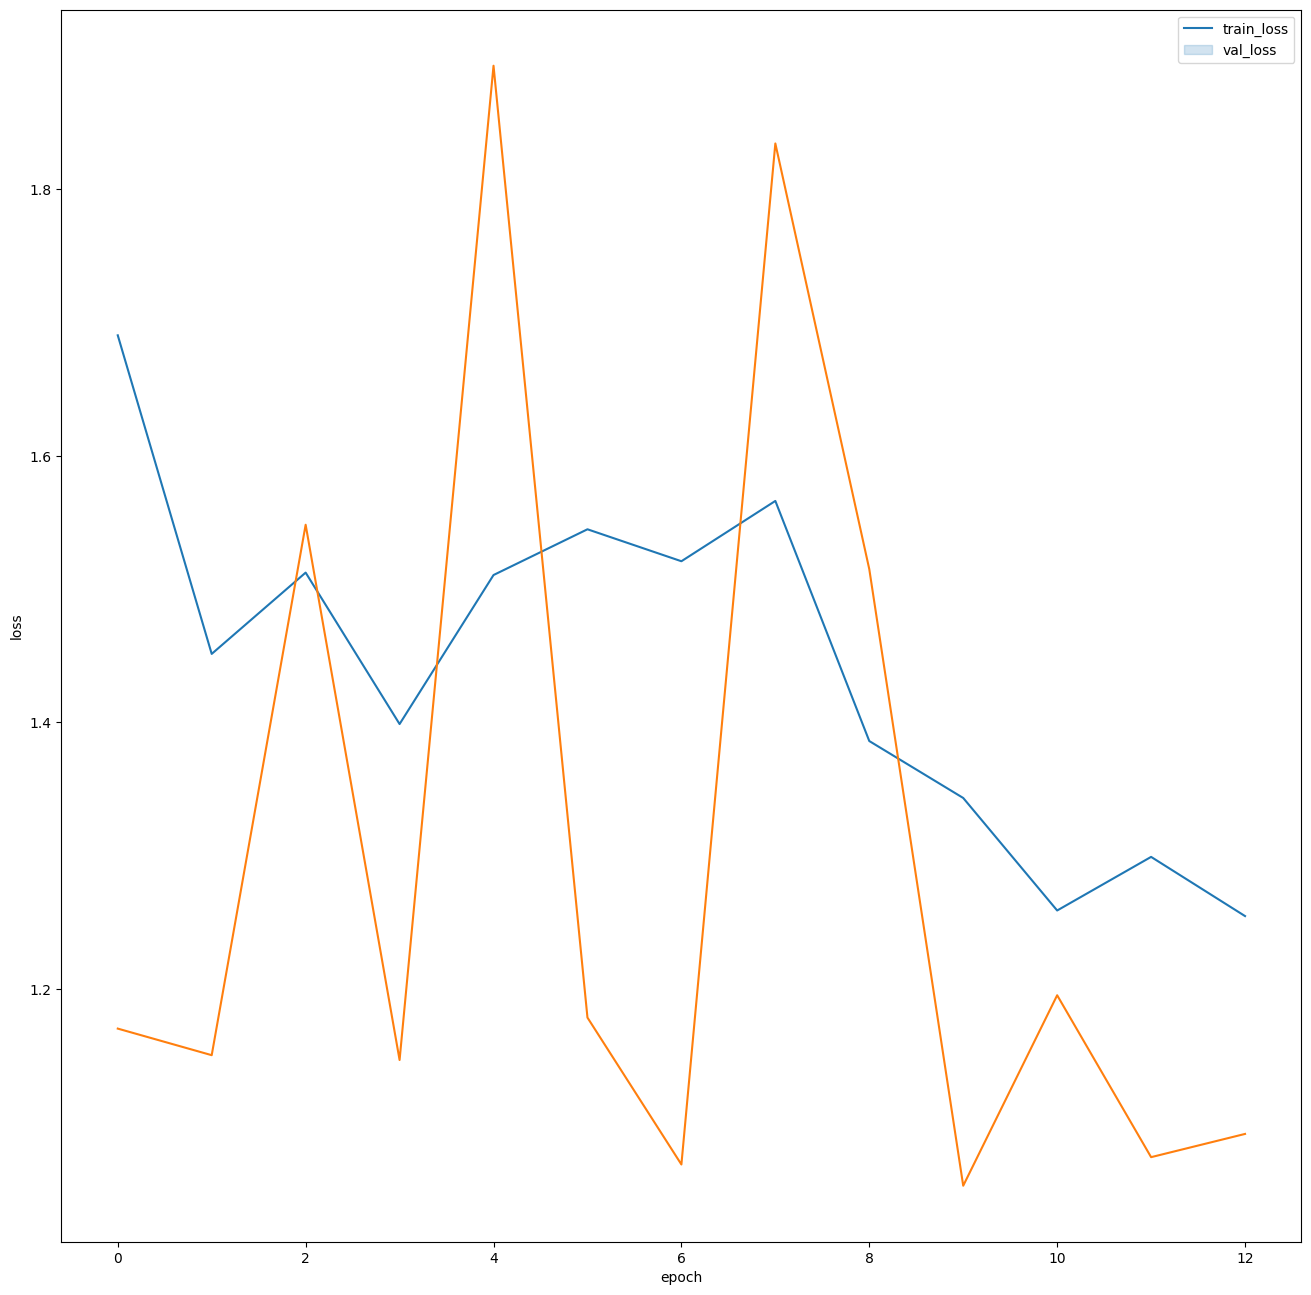

In [86]:
trainhist = pd.DataFrame(history.history)
trainhist['epoch'] = history.epoch
#Plot train loss
sns.lineplot(x = 'epoch', y = 'loss', data = trainhist)
#Plot validation loss
sns.lineplot(x = 'epoch', y = 'val_loss', data = trainhist)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

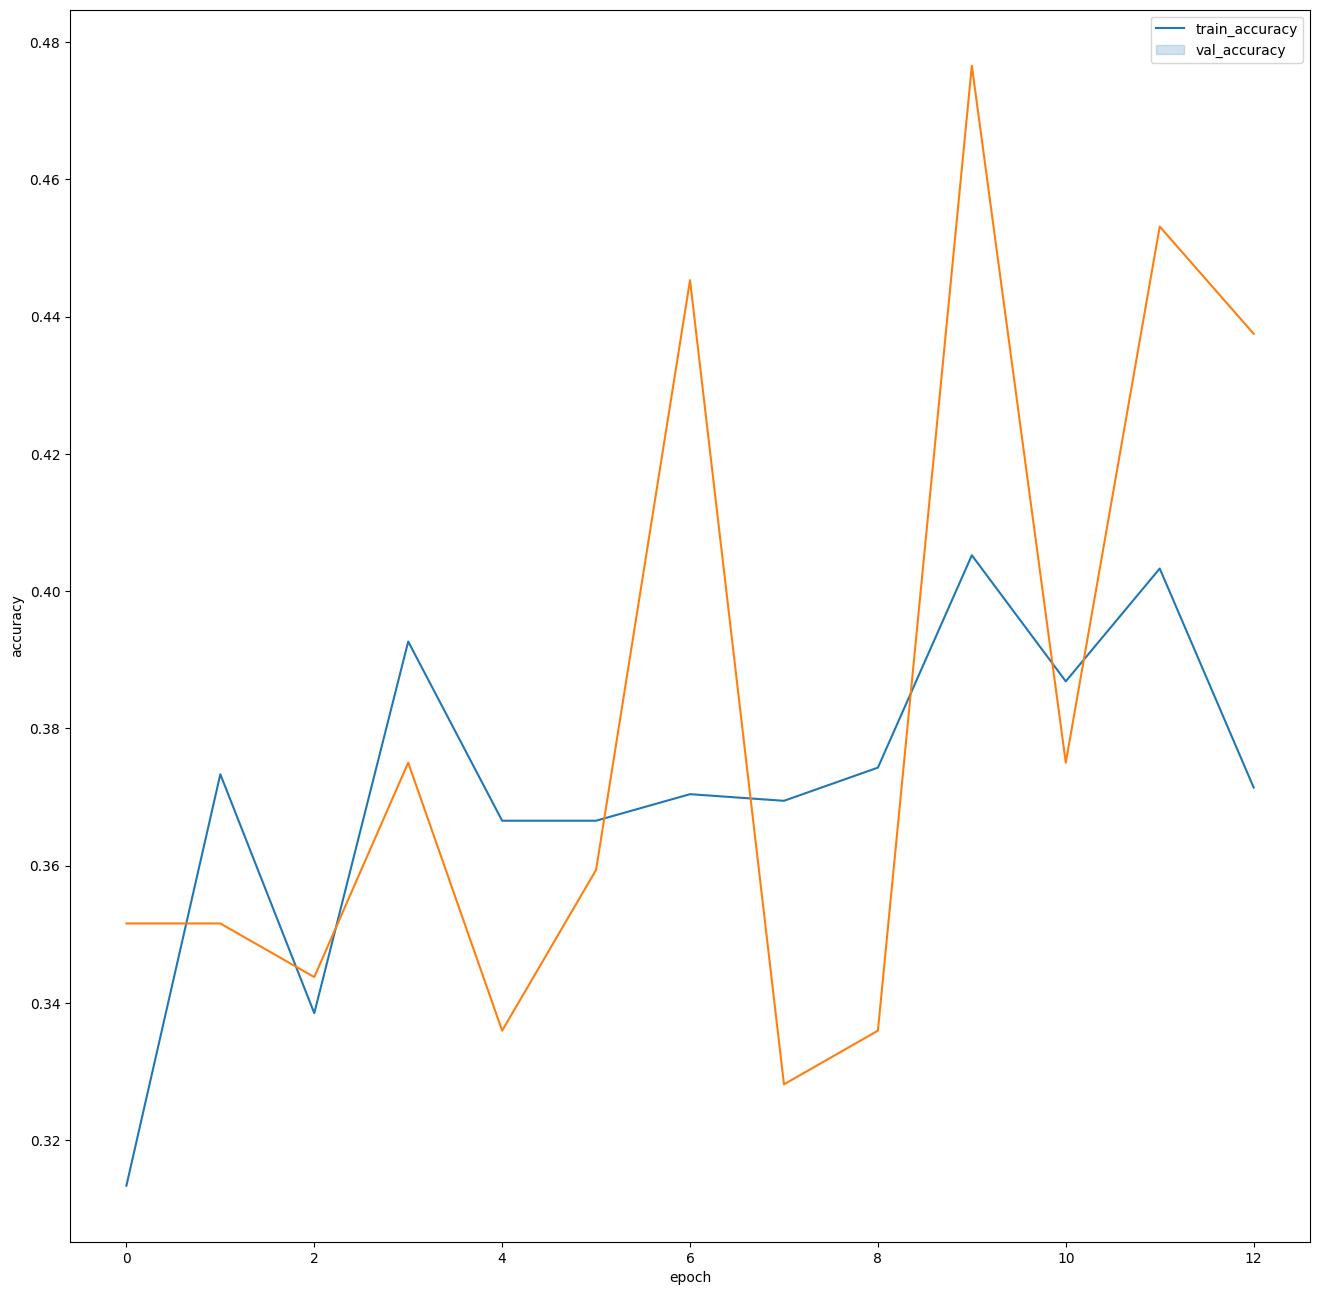

In [87]:
sns.lineplot(x = 'epoch', y = 'accuracy', data = trainhist)
#Plot validation loss
sns.lineplot(x = 'epoch', y = 'val_accuracy', data = trainhist)
#Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

This particular model may be the most unreliable of the 3. It seems that the best one to go with in this case is <br />
to either find a more suitable pre-trained model or to refine my own training process. 